In [693]:
import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numdifftools

Load data

In [67]:
root = "../"
training_data_folder = '%straining_data/web-radio/output/rec' % root
embDir = '%sembeddings' % root
what = 'artist'

uri_file = '%s/%s.emb.u' % (embDir, what)
vector_file = '%s/%s.emb.v' % (embDir, what)
header_file = '%s/%s.emb.h' % (embDir, what)
training_file = '%s/%s.dat' % (training_data_folder, what)

vectors = np.array([line.strip().split(' ') for line in codecs.open(vector_file, 'r', 'utf-8')])
heads = np.array([line.strip() for line in codecs.open(header_file, 'r', 'utf-8')])
uris = np.array([line.strip() for line in codecs.open(uri_file, 'r', 'utf-8')])

train_array = np.array([line.strip().split(' ') for line in codecs.open(training_file, 'r', 'utf-8')])
pd.DataFrame(train_array, columns=['seed', 'target', 'score']).head()


,seed,target,score
0,http://data.doremus.org/artist/d33ebb23-7b8d-3...,http://data.doremus.org/artist/6329cd86-d47a-3...,1
1,http://data.doremus.org/artist/01915146-b964-3...,http://data.doremus.org/artist/6329cd86-d47a-3...,1
2,http://data.doremus.org/artist/01915146-b964-3...,http://data.doremus.org/artist/d33ebb23-7b8d-3...,1
3,http://data.doremus.org/artist/72b3b303-5c15-3...,http://data.doremus.org/artist/6329cd86-d47a-3...,1
4,http://data.doremus.org/artist/72b3b303-5c15-3...,http://data.doremus.org/artist/d33ebb23-7b8d-3...,1


In [68]:
head_label = heads[0].split()
head_val = heads[1].split()
head_dim = []
for i in range(0, len(head_val)):
    for j in range(0, int(head_val[i])):
        head_dim.append(head_label[i])
        
head_dim.append('fake')
head_dim.append('fake')
head_dim.append('fake')
head_dim

['period',
 'period',
 'key',
 'key',
 'key',
 'genre',
 'genre',
 'genre',
 'casting',
 'casting',
 'casting',
 'mop',
 'mop',
 'mop',
 'fake',
 'fake',
 'fake']

Data pre-processing: I want to substitute the seed and target with their embeddings

In [579]:
def get_embs(x):
    # uri to embedding
    v = vectors[np.argwhere(uris == x)]
    if v.size == 0:
        result = -2. * np.ones(vectors[0].size)
    else:
        result = v[0][0]
    
    result = np.concatenate((result,  [.12, .45, .73]))
    return result.astype('float32')

In [580]:
col1 = np.array([get_embs(xi) for xi in train_array[:, 0]])
col2 = np.array([get_embs(xi) for xi in train_array[:, 1]])
col3 = np.array(train_array[:, 2]).astype('float32')
col3 = col3.reshape((col3.size, 1))

In [581]:
emb_size = col1[0].size
emb_size

17

In [582]:
training_vector = np.concatenate((col1, col2, col3), axis=1)
training_vector.shape

(12333, 35)

Split test and train

In [583]:
train, test = train_test_split(training_vector, train_size=0.7)

train_vector = train[:, : -1]
train_label = train[:, -1]
train_label = train_label.reshape((len(train_label), 1))

test_vector = test[:, :-1]
test_label = test[:, -1]
test_label = test_label.reshape((len(test_label), 1))

/Users/pasquale/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [584]:
print('Train')
print(train_vector.shape)
print(train_label.shape)
print('Test')
print(test_vector.shape)
print(test_label.shape)

Train
(8633, 34)
(8633, 1)
Test
(3700, 34)
(3700, 1)


Network

In [585]:
def next_batch(num, data, labels):
    """
    Return a total of `num` random samples and labels. 
    """
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = labels[idx]
    return data_shuffle, labels_shuffle

In [586]:
def weighted_l2(a, b, w):
    # https://stackoverflow.com/a/8861999/1218213
    q = a - b
    return np.sqrt(np.sum(w * q * q, axis=1))

In [587]:
def positive_norm(x):
    return preprocessing.normalize(np.abs(x), norm='l1')

def print_weights(w):
    y_pos = np.arange(len(w[0]))
    plt.barh(y_pos, w[0] * 100, align='center', alpha=0.5)
    plt.yticks(y_pos, head_dim)
    plt.xlabel("weights in %")
    plt.show()
    
def reset_weights():
    w = positive_norm(np.random.normal(size=[1, emb_size]))
    w = positive_norm(np.ones([1,emb_size]))
    return w

In [756]:
# Parameters
learning_rate = 0.1
num_steps = 100
batch_size = 1
display_step = 10

In [757]:
_ones = np.ones_like(w, np.float32)
max_distance = weighted_l2(_ones, _ones * -1., _ones) / 10


def compute_penalty(expected, taken, total):
    return (expected - taken) / total

def compute_similarity_split(x, w):
    a, b = np.hsplit(x, 2)
    return compute_similarity(a, b, w)

def compute_similarity(seed, target, w):     
    bs = np.where(seed >= -1, 1, 0)
    bt = np.where(target >= -1, 1, 0)
    good_mask = np.logical_and(bs, bt)
    good_count = np.count_nonzero(good_mask, axis=1)
    

    _seed = np.where(good_mask, seed, 0.)
    _target = np.where(good_mask, target, 0.)
    
    # distance
    d = weighted_l2(_seed, _target, w)

    # how much info I am not finding
    penalty = compute_penalty(np.count_nonzero(bs, axis=1), good_count, emb_size)
#     print(d)
    # score
    s = (max_distance - d) / max_distance
    
    return s * (1 - penalty), good_mask

Training

In [758]:
def dE_dW(x, w, pred, l, mask):
    a, b = np.hsplit(x, 2)
    q = a - b
    q2 = w * q * q
    dd_dW = .5 / (q2 + 10 ** - 2)
    
    ds_dW = - dd_dW / max_distance
    de_dW = ds_dW * (pred - l) * 2 / batch_size
    return np.where(mask, de_dW, 0)

ERR: 0.00122110766940111
ERR: 0.7973512559954022
ERR: 0.059551398169207334
ERR: 0.020629852809934464
ERR: 0.01416282305502334
ERR: 0.0012277999833444264
ERR: 0.18036359142515154
ERR: 0.8971765791776695
ERR: 0.005067951965639731
ERR: 0.001484367537584313
ERR: 0.004754012892994345


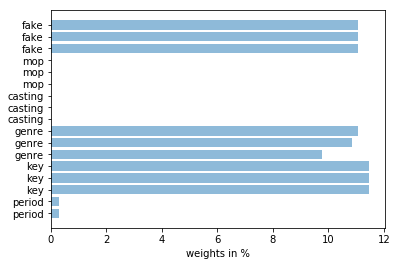

In [771]:
w = reset_weights()

for step in np.arange(0, num_steps):
#     print('--')
    v, l = next_batch(batch_size, train_vector, train_label)
    pred, mask = compute_similarity_split(v, w)
    diff = pred - l
    error = (diff ** 2).mean()
    
    if step % display_step == 0 or step == 1:
        print("ERR: " + str(error))
#     print("GT: " + str(l[0][0]))
#     print(pred)
    w -= learning_rate * dE_dW(v, w, pred, l, mask)

    w = positive_norm(w + 10 ** -40)
#     print(w)

#     pred, mask = compute_similarity_split(v, w)
#     print(pred)
#     diff = pred - l
#     error = (diff ** 2).mean()
#     print("ERR: " + str(error))


# np.set_printoptions(precision=3)
# print(w[0][-1])
print_weights(w)

In [778]:
def print_results(label, a, b):
    a = a.reshape((1, emb_size))
    b = b.reshape((1, emb_size))
    print(label + "\t{:.4f}".format(compute_similarity(a, b, w)[0][0]) + "  |  " + "{:.4f}".format(compute_similarity(a, b, np.ones_like(w))[0][0]))

In [791]:
w = reset_weights()

verdi = get_embs('http://data.doremus.org/artist/b82c0771-5280-39af-ad2e-8ace2f4ebda3')
rossini = get_embs('http://data.doremus.org/artist/c5d5735c-1095-3ed4-a20f-1208ab9567f9')
rossini_pp = get_embs('http://data.doremus.org/artist/32c2b0ff-35f1-3e65-b0ca-34aaf35f3d50')
beethoven = get_embs('http://data.doremus.org/artist/6963af5e-b126-3d40-a84b-97e0b78f5452')
mozart = get_embs('http://data.doremus.org/artist/4802a043-23bb-3b8d-a443-4a3bd22ccc63')
ravel = get_embs('http://data.doremus.org/artist/1b1205f9-b99a-3bb8-ba77-256689af2e00')
gershwin = get_embs('http://data.doremus.org/artist/5b2ec204-a456-3aa2-8ac7-25305464add8')
coltrane = get_embs('http://data.doremus.org/artist/5425efed-002f-3638-a7b0-ad379a2bf63d')

print("\t\t\t   w    |   ones")
print_results("Verdi vs Verdi: ", verdi, verdi)
print_results("Verdi vs Ravel: ", verdi, ravel)
print_results("Verdi vs Mozart: ", verdi, mozart)
print_results("Verdi vs Gershwin: ", verdi, gershwin)
print_results("Verdi vs Rossini: ", verdi, rossini)
print_results("Verdi vs Beethoven: ", verdi, beethoven)
print_results("Verdi vs Rossini (pp): ", verdi, rossini_pp)
print_results("Verdi vs Coltrane: ", verdi, coltrane)
print('__')
print_results("Beethoven vs Mozart: ", beethoven, mozart)
print_results("Rossini vs Verdi: ", rossini, verdi)



			   w    |   ones
Verdi vs Verdi: 	1.0000  |  1.0000
Verdi vs Ravel: 	0.9480  |  0.7857
Verdi vs Mozart: 	0.9421  |  0.7612
Verdi vs Gershwin: 	0.9392  |  0.7495
Verdi vs Rossini: 	0.9244  |  0.6884
Verdi vs Beethoven: 	0.9136  |  0.6438
Verdi vs Rossini (pp): 	0.8730  |  0.4766
Verdi vs Coltrane: 	0.7374  |  0.4684
__
Beethoven vs Mozart: 	0.9524  |  0.8037
Rossini vs Verdi: 	0.9244  |  0.6884


In [93]:
aida = get_embs('http://data.doremus.org/expression/4a5b26d7-6e75-3850-851f-8da9554b4115')
rigoletto = get_embs('http://data.doremus.org/expression/dc6ea9c6-88fa-3f87-80a2-a3b4fa3c0ad5')
rigoletto_pp = get_embs('http://data.doremus.org/expression/83485101-69c2-3871-8413-8ea13db5267e')
quattro_stagioni = get_embs('http://data.doremus.org/expression/6dd59267-fef0-392d-911f-7abbe676e289')
rhapsody_in_blue = get_embs('http://data.doremus.org/expression/bf957ff7-af9b-3c67-b9f4-3c8b374caaf3')
giant_steps = get_embs('http://data.doremus.org/expression/eecf626b-8996-341d-83d5-216ac70cc2de')

# print(aida)
# print(rhapsody_in_blue)
# aida.shape



print_results("Aida vs Rigoletto: ", aida, rigoletto)
print_results("Rigoletto vs Aida: ", rigoletto, aida)
print_results("Aida vs Rigoletto (pp): ",aida, rigoletto_pp)
print_results("Aida vs Le Quattro Stagioni: ", aida, quattro_stagioni)
print_results("Aida vs Rhapsody in Blue: ", aida, rhapsody_in_blue)
print_results("Aida vs Giant Steps: ", aida, giant_steps)


Aida vs Rigoletto: 1.0000
		   1.0000
Rigoletto vs Aida: 1.0000
		   1.0000
Aida vs Rigoletto (pp): 1.0000
		   1.0000
Aida vs Le Quattro Stagioni: 1.0000
		   1.0000
Aida vs Rhapsody in Blue: 1.0000
		   1.0000
Aida vs Giant Steps: 1.0000
		   1.0000


In [713]:
np.max((np.array([[1, 2]]),1))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()